In [21]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [31]:
dataset = pd.read_csv("irish.csv")
#Parse strings to datetime type
dataset = dataset.head(240)
dataset = dataset.drop(['county', 'station','latitude','longitude','rain','wetb','dewpt','vappr','rhum','msl','wdsp','wddir','sun','vis','clht','clamt'], axis = 1) 
dataset['date'] = dataset['date'].astype('datetime64[ns]') #convert from string to datetime
dataset['temp'] = dataset['temp'].astype('float32')
indexedDataset = dataset.set_index(['date'])
indexedDataset.head(5)

C:\Users\91831\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,temp
date,
2011-06-26 01:00:00,15.3
2011-06-26 02:00:00,14.7
2011-06-26 03:00:00,14.3
2011-06-26 04:00:00,14.4
2011-06-26 05:00:00,14.4


In [33]:
dataset.date.dtype

dtype('<M8[ns]')

In [11]:
indexedDataset.dropna(inplace=True)

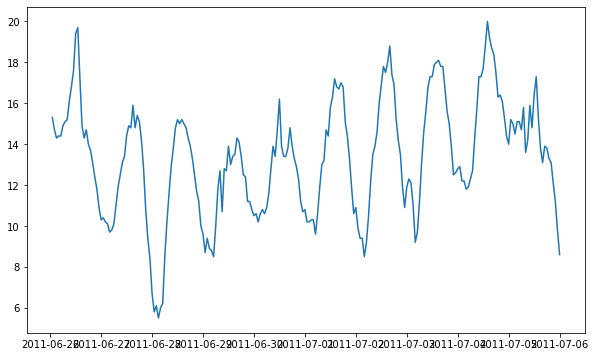

In [3]:
plt.plot(indexedDataset)

In [4]:
#Determine rolling statistics
rolmean = indexedDataset.rolling(window = 24).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = indexedDataset.rolling(window = 24).std()
print(rolmean,rolstd)

                          temp
date                          
2011-06-26 01:00:00        NaN
2011-06-26 02:00:00        NaN
2011-06-26 03:00:00        NaN
2011-06-26 04:00:00        NaN
2011-06-26 05:00:00        NaN
...                        ...
2011-07-05 20:00:00  14.737500
2011-07-05 21:00:00  14.570833
2011-07-05 22:00:00  14.400000
2011-07-05 23:00:00  14.208333
2011-07-06 00:00:00  13.983333

[240 rows x 1 columns]                          temp
date                         
2011-06-26 01:00:00       NaN
2011-06-26 02:00:00       NaN
2011-06-26 03:00:00       NaN
2011-06-26 04:00:00       NaN
2011-06-26 05:00:00       NaN
...                       ...
2011-07-05 20:00:00  1.084200
2011-07-05 21:00:00  1.169719
2011-07-05 22:00:00  1.344877
2011-07-05 23:00:00  1.640232
2011-07-06 00:00:00  2.000797

[240 rows x 1 columns]


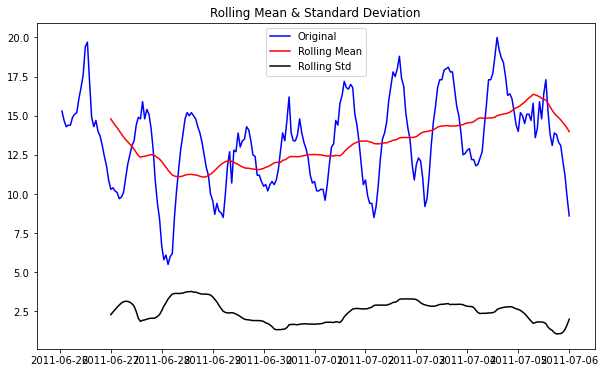

In [5]:


#Plot rolling statistics
orig = plt.plot(indexedDataset, color = 'blue', label = 'Original')
mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)



In [6]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(indexedDataset['temp'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  -2.004846
p-value                          0.284452
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


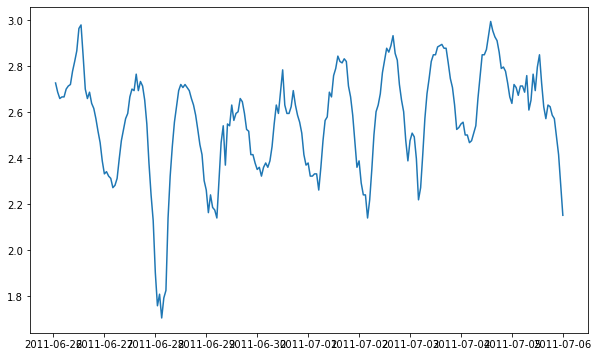

In [7]:
#Estimating trend
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

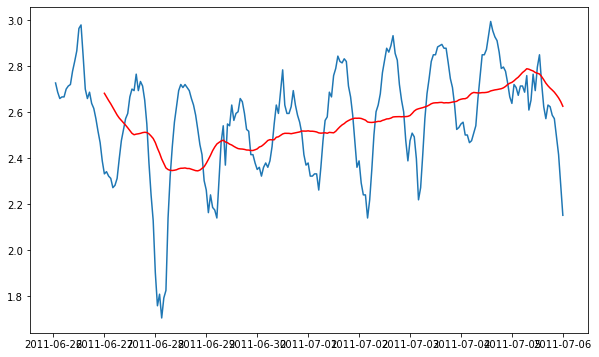

In [8]:
#The below transformation is required to make series stationary
movingAverage = indexedDataset_logScale.rolling(window = 24).mean()
movingSTD = indexedDataset_logScale.rolling(window = 24).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In [10]:


datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(70)

,temp
date,
2011-06-26 01:00:00,NaN
2011-06-26 02:00:00,NaN
2011-06-26 03:00:00,NaN
2011-06-26 04:00:00,NaN
2011-06-26 05:00:00,NaN
...,...
2011-06-28 18:00:00,0.282892
2011-06-28 19:00:00,0.241495
2011-06-28 20:00:00,0.180448


In [11]:
#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,temp
date,
2011-06-27 00:00:00,-0.350852
2011-06-27 01:00:00,-0.325105
2011-06-27 02:00:00,-0.329295
2011-06-27 03:00:00,-0.324659
2011-06-27 04:00:00,-0.348606
2011-06-27 05:00:00,-0.322314
2011-06-27 06:00:00,-0.275960
2011-06-27 07:00:00,-0.177400
2011-06-27 08:00:00,-0.088559


In [14]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=24).mean()
    movingSTD = timeseries.rolling(window=24).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['temp'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

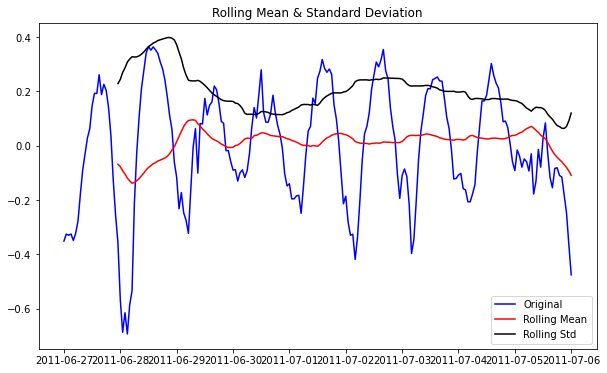

Results of Dickey Fuller Test:
Test Statistic                -7.021683e+00
p-value                        6.518783e-10
#Lags Used                     8.000000e+00
Number of Observations Used    2.080000e+02
Critical Value (1%)           -3.462186e+00
Critical Value (5%)           -2.875538e+00
Critical Value (10%)          -2.574231e+00
dtype: float64


In [15]:
test_stationarity(datasetLogScaleMinusMovingAverage)

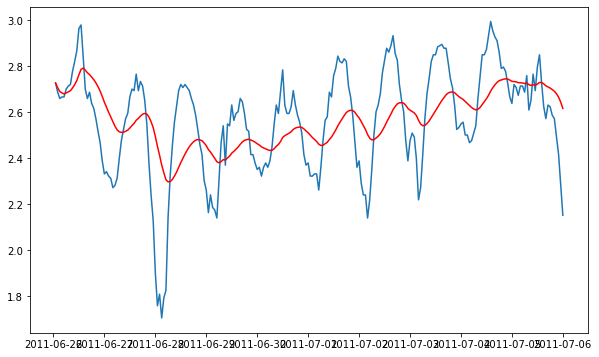

In [16]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

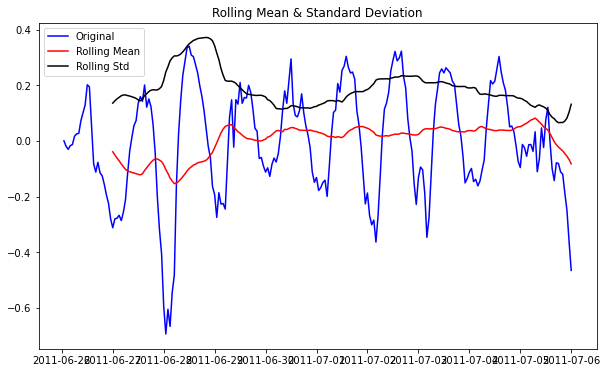

Results of Dickey Fuller Test:
Test Statistic                -7.105137e+00
p-value                        4.072125e-10
#Lags Used                     8.000000e+00
Number of Observations Used    2.310000e+02
Critical Value (1%)           -3.458980e+00
Critical Value (5%)           -2.874135e+00
Critical Value (10%)          -2.573482e+00
dtype: float64


In [17]:


datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)



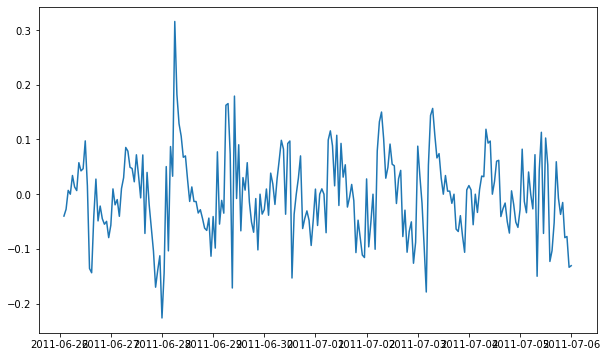

In [18]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

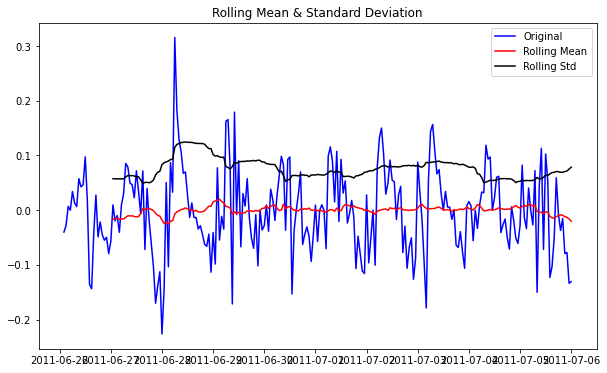

Results of Dickey Fuller Test:
Test Statistic                -7.815107e+00
p-value                        6.903466e-12
#Lags Used                     1.300000e+01
Number of Observations Used    2.250000e+02
Critical Value (1%)           -3.459752e+00
Critical Value (5%)           -2.874473e+00
Critical Value (10%)          -2.573663e+00
dtype: float64


In [19]:


datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)



C:\Users\91831\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
C:\Users\91831\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


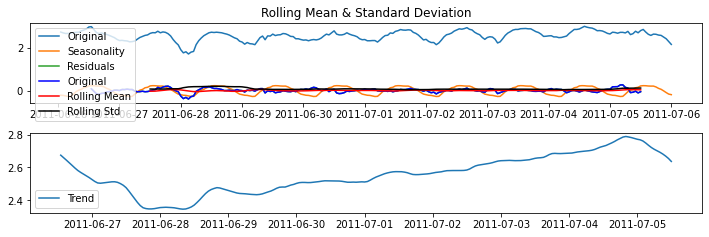

Results of Dickey Fuller Test:


KeyError: 'temp'

In [20]:
decomposition = seasonal_decompose(indexedDataset_logScale) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

#there can be cases where an observation simply consisted of trend & seasonality. In that case, there won't be 
#any residual component & that would be a null or NaN. Hence, we also remove such cases.
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

C:\Users\91831\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:666: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


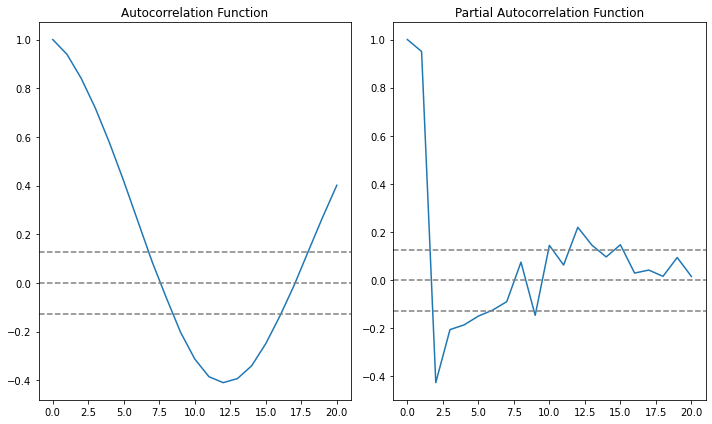

In [16]:


#ACF & PACF plots

lag_acf = acf(indexedDataset, nlags=20)
lag_pacf = pacf(indexedDataset, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(indexedDataset)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(indexedDataset)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(indexedDataset)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(indexedDataset)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()            

